In [1]:
import os 
import warnings 

import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)

from lifetimes.plotting import plot_period_transactions 
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('D:/technical test/Customer analysis.csv', sep='\t')
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

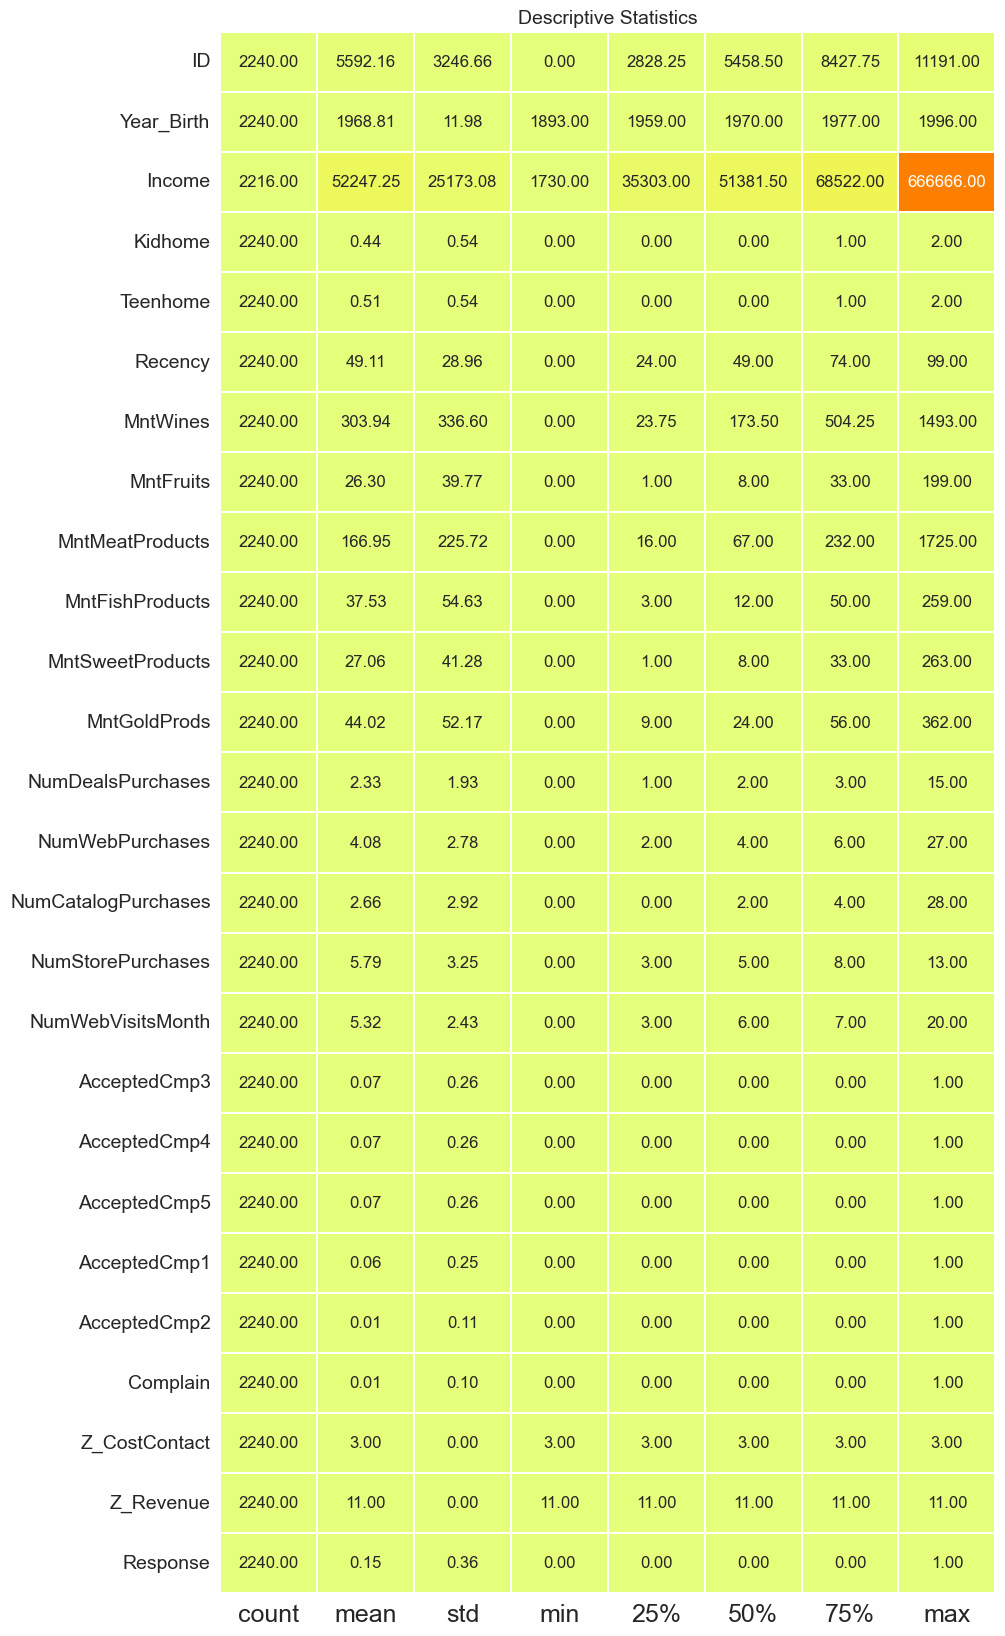

In [4]:
def desc_stats(dataframe):
    desc = dataframe.describe().T
    desc_df = pd.DataFrame(index= dataframe.columns, 
                           columns= desc.columns,
                           data= desc)
    
    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0]*0.78))
    sns.heatmap(desc_df,
                annot=True,
                cmap = "Wistia",
                fmt= '.2f',
                ax=ax,
                linecolor='white',
                linewidths = 1.3,
                cbar = False,
                annot_kws={"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(data[[col for col in data.columns if data[col].dtype != 'O']])

In [5]:
# Fill NA values in Income with median values
data['Income'] = data['Income'].fillna(data['Income'].median())
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


In [6]:
# Converting Dt_Customer to datetime object
data["Dt_Customer"] = data["Dt_Customer"].apply(pd.to_datetime, dayfirst=True, errors="coerce")
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


In [7]:
data['Dt_Customer'].min()

Timestamp('2012-07-30 00:00:00')

In [8]:
data['Dt_Customer'].max()

Timestamp('2014-06-29 00:00:00')

In [9]:
data.loc[data['ID'] == 1371]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
45,1371,1976,Graduation,Single,79941.0,0,0,2014-06-28,72,123,164,266,227,30,174,1,2,4,9,1,0,0,0,0,0,0,3,11,0


In [10]:
today_date = dt.datetime(2014, 10, 4)
today_date

datetime.datetime(2014, 10, 4, 0, 0)

In [11]:
data['last_order_date'] = today_date - pd.to_timedelta(data["Recency"], unit='D')
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,last_order_date
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2014-08-07
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2014-08-27
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,2014-09-08
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,2014-09-08
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,2014-07-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,2014-08-19
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,2014-08-09
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,2014-07-05
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,2014-09-26


In [12]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2240 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

# RFM Analysis (Recency, Frequency, Monetary)

In [13]:
data["monetary"] = data.loc[:,data.columns.str.contains("Mnt")].sum(axis=1)
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,last_order_date,monetary
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2014-08-07,1617
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2014-08-27,27
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,2014-09-08,776
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,2014-09-08,53
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,2014-07-02,422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,2014-08-19,1341
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,2014-08-09,444
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,2014-07-05,1241
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,2014-09-26,843


In [14]:
data["frequency"] = data.loc[:,data.columns.str.contains("Purchases")].sum(axis=1)
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,last_order_date,monetary,frequency
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2014-08-07,1617,25
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2014-08-27,27,6
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,2014-09-08,776,21
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,2014-09-08,53,8
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,2014-07-02,422,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,2014-08-19,1341,18
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,2014-08-09,444,22
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,2014-07-05,1241,19
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,2014-09-26,843,23


In [15]:
rfm = data[["ID","Recency","frequency","monetary"]]
rfm = rfm[rfm["frequency"] > 0]
rfm = rfm[rfm["Recency"] > 0]
rfm = rfm.reset_index(drop=True)
rfm

,ID,Recency,frequency,monetary
0,5524,58,25,1617
1,2174,38,6,27
2,4141,26,21,776
3,6182,26,8,53
4,5324,94,19,422
...,...,...,...,...
2203,10870,46,18,1341
2204,4001,56,22,444
2205,7270,91,19,1241
2206,8235,8,23,843


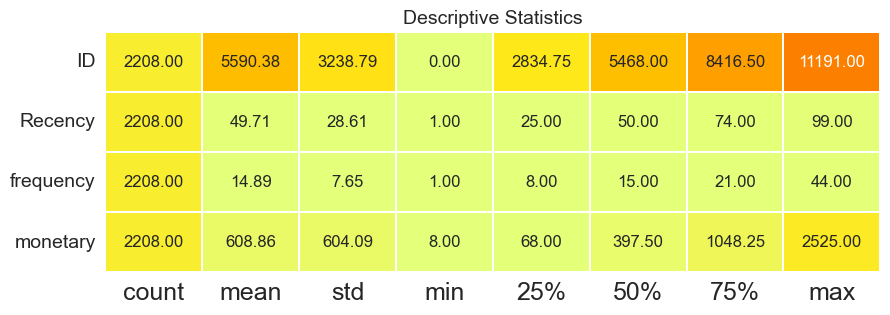

In [16]:
desc_stats(rfm[[col for col in rfm.columns if rfm[col].dtype != 'O']])

In [17]:
rfm['recency_score'] = pd.qcut(rfm['Recency'], 5, labels = [5,4,3,2,1])
rfm['frequency_score'] = pd.qcut(rfm['frequency'].rank(method = 'first'), 5, labels = [1,2,3,4,5])
rfm['monetary_score'] = pd.qcut(rfm['monetary'], 5, labels = [1,2,3,4,5])

rfm['RFM_SCORE'] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str))


seg_map = {r'[1-2][1-2]' : 'hibernating',
           r'[1-2][3-4]' : 'at_risk',
           r'[1-2][5]' : 'cant_loose',
           r'3[1-2]' : 'about_to_sleep',
           r'33' : 'need_attention',
           r'[3-4][4-5]' : 'loyal_customers',
           r'41': 'promising',
           r'51' : 'new_customers',
           r'[4-5][2-3]' : 'potential_loyalist',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)
rfm

,ID,Recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,5524,58,25,1617,3,5,5,35,loyal_customers
1,2174,38,6,27,4,1,1,41,promising
2,4141,26,21,776,4,4,4,44,loyal_customers
3,6182,26,8,53,4,2,1,42,potential_loyalist
4,5324,94,19,422,1,4,3,14,at_risk
...,...,...,...,...,...,...,...,...,...
2203,10870,46,18,1341,3,4,5,34,loyal_customers
2204,4001,56,22,444,3,5,3,35,loyal_customers
2205,7270,91,19,1241,1,4,5,14,at_risk
2206,8235,8,23,843,5,5,4,55,champions


In [18]:
rfm[['Recency','monetary','frequency','segment']].groupby('segment').agg({'mean', 'std', 'max', 'min'})

Recency                        monetary             \
                         mean max min        std         mean   max  min   
segment                                                                    
about_to_sleep      50.119048  59  41   4.895078    79.160714  1679   10   
at_risk             78.667560  99  60  11.598894   868.423592  2302    8   
cant_loose          79.819277  99  60  11.809236  1212.903614  2524  416   
champions           10.018072  20   1   5.671270  1094.150602  2349  277   
hibernating         80.145773  99  60  11.021339    84.306122  1511    8   
loyal_customers     40.297753  59  21  11.663889  1109.446629  2525  265   
need_attention      50.552632  59  41   4.367745   579.802632  2231   53   
new_customers       10.362637  20   1   5.856651    42.054945   373    8   
potential_loyalist  20.114667  40   1  11.627929   397.520000  1932    9   
promising           31.095745  40  21   5.909841    35.404255   107   11   

                                frequency                    
                           std       mean max min       std  
segment                                                      
about_to_sleep      134.375394   6.934524  11   1  2.216270  
at_risk             563.046034  17.380697  22  12  3.016951  
cant_loose          412.998807  25.813253  39  22  3.070101  
champions           469.311005  22.885542  35  18  3.598674  
hibernating         127.374900   7.072886  11   1  2.190609  
loyal_customers     474.234262  23.011236  44  17  3.891470  
need_attention      449.301829  14.750000  17  12  1.759735  
new_customers        40.790076   4.945055   7   1  1.068359  
potential_loyalist  481.644969  11.930667  17   7  3.569852  
promising            17.604569   5.042553   7   1  1.036069

In [19]:
bar = go.Bar(y = pd.DataFrame(rfm['segment'].value_counts()).index,
              x = pd.DataFrame(rfm['segment'].value_counts())['segment'].values,
              orientation = 'h')

layout = go.Layout(title = {'text' : 'Number Of Customer By Segments',
                            'y' : 0.9,
                            'x' : 0.5,
                            'xanchor' : 'center',
                            'yanchor' : 'top'},
                   xaxis = dict(title = 'Customers'),
                   template = 'plotly_white')

fig = go.Figure(data = bar, layout = layout)
fig.update_xaxes(range = [0, 400])
iplot(fig)

In [20]:
fig = go.Figure()
for i in rfm['segment'].unique():
    fig.add_trace(go.Scatter(x=rfm[rfm['segment']==i]['Recency'],
                           y=rfm[rfm['segment']==i]['frequency'],
                           mode='markers', name=str(i),showlegend = True,
                           marker = dict(size = 10,opacity = 0.6)))

fig.update_layout(title={'text': "Recency & Frequency by Segments",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  legend=dict(x=0.95,
                              y=1,
                              bgcolor='rgba(255, 255, 255, 0)'),
                  xaxis = dict(title='Recency'),
                  yaxis=dict(title='Frequency'),
                  template='plotly_white')

fig.show() 

# K-Means Clustering

In [21]:
kmeans_data = rfm.loc[:,['recency_score','frequency_score']]

inertia = []

k = [1,2,3,4,5,6,7,8,9]

for i in k:
    
    kmean = KMeans(n_clusters = i)
    kmean.fit(kmeans_data)
    inertia.append(kmean.inertia_)
    
scatter = go.Scatter(x = k, y = inertia, mode = 'lines + markers', marker = dict(size= 10))

layout = go.Layout(title = {'text' : 'Elbow Method',
                            'y' : 0.9,
                            'x' : 0.5,
                            'xanchor' : 'center',
                            'yanchor' : 'top'},
                   width = 650,
                   height = 470,
                   xaxis = dict(title = 'Number Of Clusters'),
                   yaxis = dict(title = 'Sum of Squared Distance'),
                   template = 'plotly_white')

fig = go.Figure(data = scatter, layout = layout)
iplot(fig)

In [22]:
kmeans = KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(kmeans_data)
print('Silhoutte Score : {}'.format(round(metrics.silhouette_score(kmeans_data, kmeans.labels_), 3))) 

Silhoutte Score : 0.443


In [23]:
rfm['k_means_segment'] = kmeans.labels_
rfm['k_means_segment'] = rfm['k_means_segment'].astype(str)
rfm[['Recency', 'monetary', 'frequency', 'k_means_segment']].groupby('k_means_segment').agg({'mean','std','max','min'})

Recency                        monetary             \
                      mean max min        std         mean   max  min   
k_means_segment                                                         
0                30.668582  59   1  17.381442  1104.582375  2525  265   
1                20.373214  40   1  11.725467   278.973214  1932    8   
2                70.273973  99  41  16.989942    82.614481  1679    8   
3                75.504065  99  41  14.473819   925.738211  2524    8   

                             frequency                    
                        std       mean max min       std  
k_means_segment                                           
0                472.277613  22.971264  44  17  3.797809  
1                429.032015   9.639286  17   1  4.421677  
2                129.608725   7.027397  11   1  2.197867  
3                549.244703  19.331707  39  12  4.969341

In [62]:
bar = go.Bar(y = pd.DataFrame(rfm['k_means_segment'].value_counts()).index,
              x = pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values,
              name = str(pd.DataFrame(rfm['k_means_segment'].value_counts())['k_means_segment'].values),
              orientation = 'h')

layout = go.Layout(title = {'text' : "Number Of Customer by K-Means Segment",
                            "y" : 0.9,
                            "x" : 0.5,
                            "xanchor" : "center",
                            "yanchor" : "top"},
                   xaxis = dict(title = 'Customers'),
                   template = 'plotly_white')

fig = go.Figure(data = bar, layout = layout)
fig.update_xaxes(range = [0,700])
iplot(fig)

In [24]:
rfm

,ID,Recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment,k_means_segment
0,5524,58,25,1617,3,5,5,35,loyal_customers,0
1,2174,38,6,27,4,1,1,41,promising,1
2,4141,26,21,776,4,4,4,44,loyal_customers,0
3,6182,26,8,53,4,2,1,42,potential_loyalist,1
4,5324,94,19,422,1,4,3,14,at_risk,3
...,...,...,...,...,...,...,...,...,...,...
2203,10870,46,18,1341,3,4,5,34,loyal_customers,0
2204,4001,56,22,444,3,5,3,35,loyal_customers,0
2205,7270,91,19,1241,1,4,5,14,at_risk,3
2206,8235,8,23,843,5,5,4,55,champions,0


In [38]:
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,last_order_date,monetary,frequency
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2014-08-07,1617,25
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2014-08-27,27,6
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,2014-09-08,776,21
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,2014-09-08,53,8
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,2014-07-02,422,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,2014-08-19,1341,18
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,2014-08-09,444,22
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,2014-07-05,1241,19
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,2014-09-26,843,23


In [51]:
merge = data.merge(rfm, on='ID', how='inner')
merge

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency_x,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,last_order_date,monetary_x,frequency_x,Recency_y,frequency_y,monetary_y,recency_score,frequency_score,monetary_score,RFM_SCORE,segment,k_means_segment
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2014-08-07,1617,25,58,25,1617,3,5,5,35,loyal_customers,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2014-08-27,27,6,38,6,27,4,1,1,41,promising,1
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,2014-09-08,776,21,26,21,776,4,4,4,44,loyal_customers,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,2014-09-08,53,8,26,8,53,4,2,1,42,potential_loyalist,1
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,2014-07-02,422,19,94,19,422,1,4,3,14,at_risk,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,2014-08-19,1341,18,46,18,1341,3,4,5,34,loyal_customers,0
2204,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,2014-08-09,444,22,56,22,444,3,5,3,35,loyal_customers,0
2205,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,2014-07-05,1241,19,91,19,1241,1,4,5,14,at_risk,3
2206,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,2014-09-26,843,23,8,23,843,5,5,4,55,champions,0


In [59]:
merge['age'] = 2014 - merge['Year_Birth']
merge

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency_x,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,last_order_date,monetary_x,frequency_x,Recency_y,frequency_y,monetary_y,recency_score,frequency_score,monetary_score,RFM_SCORE,segment,k_means_segment,age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2014-08-07,1617,25,58,25,1617,3,5,5,35,loyal_customers,0,57
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2014-08-27,27,6,38,6,27,4,1,1,41,promising,1,60
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,2014-09-08,776,21,26,21,776,4,4,4,44,loyal_customers,0,49
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,2014-09-08,53,8,26,8,53,4,2,1,42,potential_loyalist,1,30
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,2014-07-02,422,19,94,19,422,1,4,3,14,at_risk,3,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,2014-08-19,1341,18,46,18,1341,3,4,5,34,loyal_customers,0,47
2204,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,2014-08-09,444,22,56,22,444,3,5,3,35,loyal_customers,0,68
2205,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,2014-07-05,1241,19,91,19,1241,1,4,5,14,at_risk,3,33
2206,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,2014-09-26,843,23,8,23,843,5,5,4,55,champions,0,58


In [61]:
merge['k_means_segment'] = merge['k_means_segment'].astype(str)
merge[['age', 'Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntSweetProducts', 'MntGoldProds', 'k_means_segment']].groupby('k_means_segment').agg({'mean', 'max'})

age             Income              MntWines        \
                      mean  max          mean       max        mean   max   
k_means_segment                                                             
0                46.712644   71  68085.661877  160803.0  567.442529  1478   
1                43.591071  121  42754.161607  666666.0  134.003571  1462   
2                42.923679  114  34062.647750   86580.0   32.454012  1115   
3                47.053659   73  62435.705691  157243.0  466.491057  1493   

                 MntFruits      MntMeatProducts       MntSweetProducts       \
                      mean  max            mean   max             mean  max   
k_means_segment                                                               
0                48.434866  199      298.785441  1725        49.019157  263   
1                13.112500  194       74.582143   981        11.691071  176   
2                 4.430528   86       21.185910  1607         4.818004  160   
3                38.201626  194      263.252033  1582        41.401626  196   

                MntGoldProds       
                        mean  max  
k_means_segment                    
0                  73.722222  362  
1                  26.096429  262  
2                  13.504892  147  
3                  60.850407  291

# Customer Life Time Value (CLTV) 

In [26]:
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,last_order_date,monetary,frequency
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,2014-08-07,1617,25
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2014-08-27,27,6
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,2014-09-08,776,21
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,2014-09-08,53,8
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,2014-07-02,422,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0,2014-08-19,1341,18
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0,2014-08-09,444,22
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0,2014-07-05,1241,19
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0,2014-09-26,843,23


In [27]:
cltv = pd.DataFrame()
cltv['Recency'] = (data["last_order_date"] - data["Dt_Customer"]).dt.days
cltv['T'] = (today_date - data['Dt_Customer']).dt.days
cltv['frequency'] = data['frequency']
cltv['monetary'] = data['monetary']
cltv.index = data["ID"]
cltv

,Recency,T,frequency,monetary
ID,,,,
5524,702,760,25,1617
2174,172,210,6,27
4141,383,409,21,776
6182,210,236,8,53
5324,164,258,19,422
...,...,...,...,...
10870,432,478,18,1341
4001,60,116,22,444
7270,161,252,19,1241


In [28]:
cltv.loc[cltv['Recency'] < 0]

,Recency,T,frequency,monetary
ID,,,,


In [29]:
cltv.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,2240.0,401.472768,203.482758,0.0,226.00,402.0,575.25,791.0
T,2240.0,450.582143,202.122512,97.0,277.75,452.5,626.00,796.0
frequency,2240.0,14.862054,7.677173,0.0,8.00,15.0,21.00,44.0
monetary,2240.0,605.798214,602.249288,5.0,68.75,396.0,1045.50,2525.0


In [30]:
# Average Order Value
cltv["monetary"] = cltv["monetary"] / cltv["frequency"]

# Recency & Tenure
cltv["Recency"] = cltv["Recency"] // 7
cltv["T"] = cltv["T"] // 7

# Frequency
cltv = cltv[(cltv['frequency'] > 1)]

In [31]:
bgf = BetaGeoFitter(penalizer_coef=0.001) #avoid overfitting

bgf.fit(cltv['frequency'],
        cltv['Recency'],
        cltv['T'])

<lifetimes.BetaGeoFitter: fitted with 2232 subjects, a: 0.08, alpha: 5.07, b: 4.38, r: 1.67>

In [32]:
#Top 10 Expected Number of Transaction (1 Week)
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv['frequency'],
                                                        cltv['Recency'],
                                                        cltv['T']).sort_values(ascending = False).head(10)

ID
4619     1.229089
6892     1.119331
4828     1.088184
1        0.974738
9369     0.962350
10846    0.942306
1446     0.936313
6815     0.932349
10102    0.921632
4399     0.921129
dtype: float64

In [33]:
bgf.conditional_expected_number_of_purchases_up_to_time(4,
                                                        cltv['frequency'],
                                                        cltv['Recency'],
                                                        cltv['T']).sort_values(ascending = False).head(10)

ID
4619     4.893321
6892     4.455419
4828     4.329824
1        3.878623
9369     3.836460
10846    3.751752
1446     3.731974
6815     3.712827
10102    3.670721
4399     3.664532
dtype: float64

In [34]:
bgf.predict(4,
            cltv['frequency'],
            cltv['Recency'],
            cltv['T']).sum()

2010.1572579916533

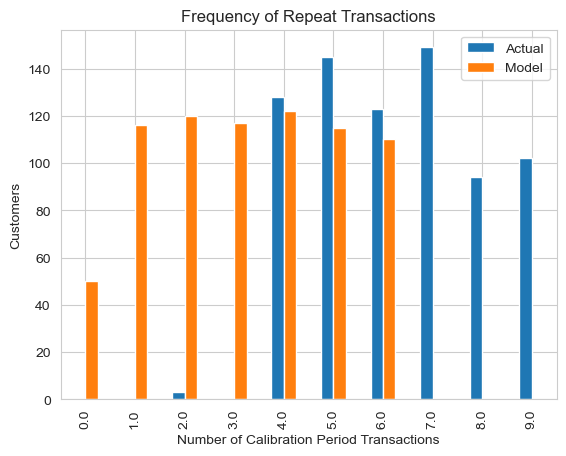

In [35]:
plot_period_transactions(bgf)
plt.show()

In [36]:
ggf = GammaGammaFitter(penalizer_coef = 0.01)

ggf.fit(cltv['frequency'], cltv['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2232 subjects, p: 3.06, q: 0.84, v: 3.04>

In [37]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending = False).head(10)

NameError: name 'cltv_df' is not defined

In [ ]:
cltv = ggf.customer_lifetime_value(bgf, cltv['frequency'],
                                     cltv['Recency'], cltv['T'],
                                     cltv['monetary'], time = 6,
                                     freq = 'W',discount_rate = 0.01)

cltv = cltv.reset_index()
cltv.sort_values(by = 'clv', ascending= False).head(10)